In [1]:
import tensorflow.keras as keras
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import sys
import glob
from tqdm.notebook import tqdm
import ipywidgets
from ipywidgets import IntProgress

In [2]:
# paths_format = "../face-utility/frames/*.jpg"
# paths = sorted(glob.glob(paths_format))

size = 128

nb = "0"
path_E = "saved-models/E_training_" + nb +".h5"
path_G = "saved-models/G_training_" + nb +".h5"
path_D = "saved-models/D_training_" + nb +".h5"

E = keras.models.load_model(path_E)
G = keras.models.load_model(path_G)
D = keras.models.load_model(path_D)

In [3]:
def encode(images) :
    res = []
    for im in tqdm(images) :
        im = np.expand_dims(im, 0)
        res.append(E(im)[0][0])
    return res
    
def decode(represetations) :
    res = []
    for r in tqdm(represetations) :
        im = G(np.expand_dims(r, 0))
        res.append(im[0])
    return res

In [5]:
def read_images(paths) :
    res = []
    for p in paths :
        im = Image.open(p)
        im = im.resize((size,size))
        im = np.array(im) / 256
        im = im.astype(np.float32)
        res.append(im)
    return res

In [4]:
from utils import PARSER
args = PARSER.parse_args(['--config_path', 'configs/carracing.config'])
def ds_gen():
    dirname = 'results/{}/{}/record5'.format(args.exp_name, args.env_name)
    filenames = sorted(os.listdir(dirname)[:10000]) # only use first 10k episodes
    n = len(filenames)
    im = []
    for j, fname in enumerate(filenames):
        if not fname.endswith('npz'): 
            continue
        file_path = os.path.join(dirname, fname)
        with np.load(file_path) as data:
            N = data['obs'].shape[0]
            for i, img in enumerate(data['obs']):
                img_i = img / 255.0
#                 im.append(im.astype(np.float32))
                yield img_i 
#     return im

im_dataset = tf.data.Dataset.from_generator(ds_gen, output_types=tf.float32, output_shapes=(64, 64, 3))
batch_gen = iter(im_dataset)

In [5]:
# encoded = encode(read_images(paths))
encoded = encode(batch_gen)

0it [00:00, ?it/s]

In [6]:
decoded = decode(encoded)

  0%|          | 0/1213 [00:00<?, ?it/s]

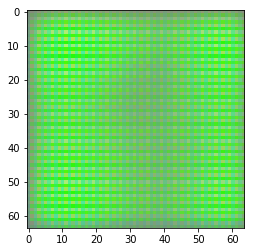

In [7]:
from matplotlib import animation, rc
from IPython.display import HTML

ims = []
fig = plt.figure()
for im in decoded :
    ims.append([plt.imshow(im, animated=True)])
ani1 = animation.ArtistAnimation(fig, ims, interval=20, blit=True,
                                repeat_delay=100)
HTML(ani1.to_html5_video())

In [11]:
from matplotlib import animation, rc
from IPython.display import HTML

plt.rcParams['animation.ffmpeg_path'] = u'/usr/bin/ffmpeg'